In [1]:
from TCSPC import *
plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
EGFP = Phasor([0.497,0.503],[2.43,3.07])

In [3]:
# tdata = np.loadtxt('EGFPt.csv')
# ydata = np.loadtxt('EGFPy2.csv')

In [4]:
def trim_rescale_data(tdata,ydata,end =int(0.6*380),rescale = True):
    max_idx = np.argmax(ydata) #index of data point with maximum photon count N(0)
    tdata = tdata[:end-max_idx] #start from t = 0
    ydata = ydata[max_idx:end]  #start from max.
    if rescale == True:
        yerr = ydata/ydata[0]*np.sqrt(1/ydata+1/ydata[0]) #error after scaling
        ydata = ydata/ydata[0] # scale y data such that the beginning is 1 
    else:
        yerr = np.sqrt(ydata)
    weights = 1/yerr #weighted by 1/yerr, yerr is error after scaling ydata
    return tdata,ydata,weights

In [5]:
def trim_rescale_data(tdata,ydata,r = 10,rescale = True):
    '''Trim and rescale data (if rescale ==True)
       tdata    EGFP.t
       ydata    EGFP.y2 
       r        select points with y>r*max(y)
       rescale  True to rescale, False won't rescale'''
     #select points >r counts only
    ydata = ydata[ydata>r]
    #trim away IRF
    ydata = ydata[np.argmax(ydata):]
    #set tdata to same length, start from t = 0
    tdata = tdata[:len(ydata)]
    if rescale == True:
        yerr = ydata/ydata[0]*np.sqrt(1/ydata+1/ydata[0]) #error after scaling
        ydata = ydata/ydata[0] # scale y data such that the beginning is 1 
    else:
        yerr = np.sqrt(ydata)
    weights = 1/yerr #weighted by 1/yerr, yerr is error after scaling ydata
    return tdata,ydata,weights

def exp(t, A, tau):
    return A * np.exp(-t/tau)

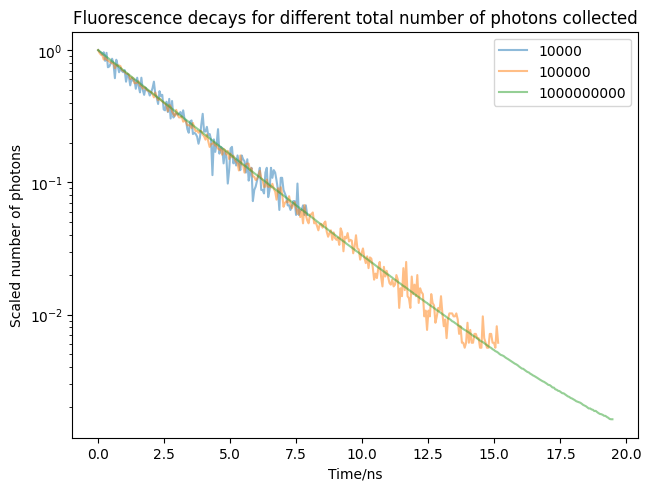

In [6]:
for n_photon in [int(1e4),int(1e5),int(1e9)]:
    EGFP.n_photon = n_photon
    EGFP.multi_exp_data()
    tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2,rescale = True)
    plt.plot(tdata,ydata,alpha = 0.5,label = str(n_photon))
plt.legend()
plt.title('Fluorescence decays for different total number of photons collected' )
plt.xlabel('Time/ns')
plt.ylabel('Scaled number of photons')
plt.yscale('log')

In [7]:
def poisson_deviance_residual(observed, expected):
    '''Return Poisson deviance residual array for given observed data and expected (model) '''
    residual=  np.sign(observed-expected)*np.sqrt(abs(2 *  (observed* np.log(observed/ expected) - (observed- expected)))) #residual array
    return residual

def residual(p, t, data):
    '''Return residual array for lmfit.minimizer to minimize in the sum of squares sense
       Inputs:
       p         lmfit.Parameters() object
       t         time array (independent variable)
       data      data array to be fitted'''
    v = p.valuesdict() #obtain dictionary of parameter values
    expected = 0
    if 'c' in v:
        expected = v['c'] #constant background
    M = 1
    while f'A{M}' in v:
        expected += exp(t, v[f'A{M}'], v[f'tau{M}']) #add exponential component
        M += 1
    return poisson_deviance_residual(data, expected) #lmfit.minimizer minimize the residual array in the sum of squared sense

def initial_params(M,A_guess,tau_guess,c_guess = 0,rescale = True,bg_removed = False):
    '''Create and return initial parameters of fit (lmfit.Parmaeters() object)
       Input:
       M          number of lifetime components
       A_guess    np.array of A1,...AM amplitudes guess
       tau_guess  np.array of tau1,...tauM lifetimes guess
       c_guess    constant background offset guess
       rescale    True if the ydata is rescaled
       bg_removed True if bg is removed
       '''
    p = lmfit.Parameters()
    if bg_removed == False:
        p.add_many(('c', c_guess, True, 0)) #constant background
    for i in range(1,M+1): #for each component
        p.add_many((f'A{i}', A_guess[i-1], True,0)) #amplitude
    for i in range(1,M+1):
        p.add_many((f'tau{i}', tau_guess[i-1], True, 0)) #lifetime
    if rescale == True:
        p[f'A{M}'].set(expr = f'1 {"".join([f"- A{i}" for i in range(1,M)])}') #fix the amplitude of last component
    return p

def chi2(params):
    '''Return chi2 from given parameters (np.array)'''
    M = int((len(params)-1)/2)
    p = initial_params(M,params[1:M+1],params[M+1:],c_guess=params[0],rescale = False)
    return np.dot(residual(p, tdata, ydata),residual(p, tdata, ydata))


### Bi-exp decay fit to EGFP

#### Rescaled data:

In [8]:
EGFP.n_photon = int(1e5)
EGFP.multi_exp_data()
tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2-EGFP.bg*EGFP.run_time/380)
p1 = initial_params(2,EGFP.amp,EGFP.tau)
p1['c'].set(value = 0, vary = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method='powell')

print(lmfit.fit_report(mi1))


[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 169
    # data points      = 281
    # variables        = 3
    chi-square         = 0.14629873
    reduced chi-square = 5.2625e-04
    Akaike info crit   = -2118.48906
    Bayesian info crit = -2107.57400
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     0 (fixed)
    A1:    0.46427972 +/-        nan (nan%) (init = 0.497)
    A2:    0.53572028 +/- 0.00000000 (0.00%) == '1 - A1'
    tau1:  2.46544849 +/-        nan (nan%) (init = 2.43)
    tau2:  3.00922977 +/-        nan (nan%) (init = 3.07)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/uncertainties/core.py:173: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


### No rescale

Without background:

In [ ]:
#generate data for a particular total collected photon number
EGFP.n_photon = int(1e5)
EGFP.multi_exp_data()

In [10]:
y_no_bg = EGFP.y2-EGFP.bg*EGFP.run_time/EGFP.n_bins
y_with_bg = EGFP.y2
tdata,ydata,weights = trim_rescale_data(EGFP.t,y_no_bg,rescale = False) #bg removed
p1 = initial_params(2,np.max(EGFP.y2)*EGFP.amp,EGFP.tau,rescale = False)
p1['c'].set(value = 0, vary = False)
mi2 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')

print(lmfit.fit_report(mi2))



[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 120
    # data points      = 279
    # variables        = 4
    chi-square         = 290.614187
    reduced chi-square = 1.05677886
    Akaike info crit   = 19.3789559
    Bayesian info crit = 33.9038030
[[Variables]]
    c:     0 (fixed)
    A1:    917.446932 +/- 118.683172 (12.94%) (init = 969.15)
    A2:    979.877343 +/- 118.827280 (12.13%) (init = 980.85)
    tau1:  2.42397757 +/- 0.08600744 (3.55%) (init = 2.43)
    tau2:  3.06899739 +/- 0.06483058 (2.11%) (init = 3.07)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2)     = -0.995
    C(A1, tau2)   = 0.631
    C(A2, tau2)   = -0.592
    C(A2, tau1)   = -0.515
    C(A1, tau1)   = 0.454
    C(tau1, tau2) = -0.357


In [11]:
tdata,ydata,weights = trim_rescale_data(EGFP.t,y_with_bg,rescale = False) #bg removed
p1['c'].set(value = 0, vary = True)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')
print(lmfit.fit_report(mi1))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 251
    # data points      = 288
    # variables        = 5
    chi-square         = 294.600606
    reduced chi-square = 1.04099154
    Akaike info crit   = 16.5261037
    Bayesian info crit = 34.8409061
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     1.40919469 +/- 1.23130754 (87.38%) (init = 0)
    A1:    912.839406 +/-        nan (nan%) (init = 969.15)
    A2:    985.025783 +/-        nan (nan%) (init = 980.85)
    tau1:  2.42751638 +/- 0.12158969 (5.01%) (init = 2.43)
    tau2:  3.05574675 +/- 0.10003810 (3.27%) (init = 3.07)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau1, tau2) = -1.253
    C(c, tau2)    = -0.962
    C(c, tau1)    = 0.859


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])


### Mono-exp decay fit to EGFP

In [12]:
p1 = initial_params(1,[np.max(ydata)],EGFP.tau,rescale = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')
print(lmfit.fit_report(mi1))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 378
    # data points      = 288
    # variables        = 3
    chi-square         = 295.398415
    reduced chi-square = 1.03648567
    Akaike info crit   = 13.3049834
    Bayesian info crit = 24.2938648
[[Variables]]
    c:     2.87269349 +/- 0.65015565 (22.63%) (init = 0)
    A1:    1883.78855 +/- 9.35257012 (0.50%) (init = 1950)
    tau1:  2.75714435 +/- 0.01390592 (0.50%) (init = 2.43)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, tau1)  = -0.712
    C(A1, tau1) = -0.712
    C(c, A1)    = 0.329


### Triple-exp fit

In [13]:

p1 = initial_params(3,[np.max(EGFP.y2*0.49),np.max(EGFP.y2)*0.51,100],EGFP.tau+[10],rescale = False)
mi3 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')

print(lmfit.fit_report(mi3))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 480
    # data points      = 288
    # variables        = 7
    chi-square         = 294.446017
    reduced chi-square = 1.04785059
    Akaike info crit   = 20.3749382
    Bayesian info crit = 46.0156616
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     1.86320162 +/- 1.64428707 (88.25%) (init = 0)
    A1:    934.985462 +/- 59.6327115 (6.38%) (init = 955.5)
    A2:    942.144275 +/- 156.010817 (16.56%) (init = 994.5)
    A3:    18.7971951 +/-        nan (nan%) (init = 100)
    tau1:  2.53578649 +/- 0.30836241 (12.16%) (init = 2.43)
    tau2:  2.99509176 +/- 0.28947604 (9.67%) (init = 3.07)
    tau3:  1.28835090 +/-        nan (nan%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2)     = -2.110
    C(tau1, tau2) = -0.975
    C(c, tau1)    = 0.942
    C(c, tau2)    = -0.928
    C(c, A1)      = -0.896
    C(A1, tau2)   = 0.804
    C(A1, tau1)   = 0.371
    

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])


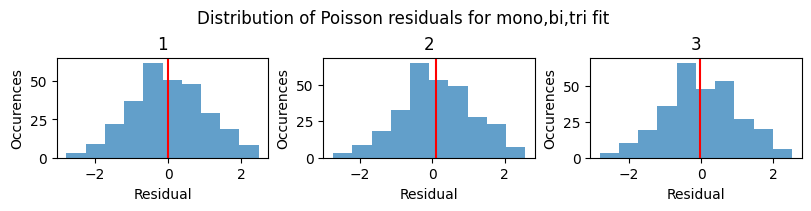

In [14]:
fig,ax = plt.subplots(ncols=3,figsize = (8,2))
fig.suptitle('Distribution of Poisson residuals for mono,bi,tri fit ')
for i in range(3):
    mi = [mi1,mi2,mi3][i]
    resid = residual(mi.params,tdata,ydata)
    ax[i].hist(resid,alpha = 0.7)
    ax[i].axvline(np.mean(residual(mi.params,tdata,ydata)),c='r',label = 'mean')
    ax[i].set_title(range(1,4)[i])
    ax[i].set_xlabel('Residual')
    ax[i].set_ylabel('Occurences')


## Get 100 simulation at each point (bi-exp decay)


In [15]:
def MLEfit(N,tdata,ydata,method ='powell',r=100,rescale=False):

    tdata, ydata, weights = trim_rescale_data(tdata,ydata, r=r, rescale=rescale)
    p1 = initial_params(N, [np.max(ydata * 0.49), np.max(ydata) * 0.51], EGFP.tau, rescale=rescale)
    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)
MLEfit(2,EGFP.t,EGFP.sim_data[2])

,c,A1,A2,tau1,tau2
0,31.050835,0.489624,0.510376,2.420671,3.066687


In [41]:
def MLEfit(N,tdata,ydata,method ='powell',r=10,rescale=False,bg=True):
    tdata, ydata, weights = trim_rescale_data(tdata,ydata, r=r, rescale=rescale)
    p1 = initial_params(N, np.max(ydata)*EGFP.amp, EGFP.tau, rescale=rescale)
    if bg == False: #background removed
      p1['c'].set(value = 0,vary = False)

    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)

def val_df(N,method='powell',sim_data=EGFP.sim_data,r=10,rescale=False,bg=True):
  '''Create dataframe of fitted parameters for 100 simulations'''
  df_list = []
  for j in range(100):
    df_list.append( MLEfit(N,EGFP.t,sim_data[j],method='powell',r=10,rescale=rescale,bg=bg))
    df= pd.concat(df_list).reset_index()
  return df.drop(['index'],axis =1)

#this would take 10 mins to run
N=2 #components
EGFP.y_list = np.zeros((20,100,380))
EGFP.y_no_bg_list = np.zeros((20,100,380))
n_photon_arr = np.logspace(4,9,20)
df_list = []
for i in range(len(n_photon_arr)):
  EGFP.n_photon = n_photon_arr[i]
  EGFP.repeat_sim(100)
  EGFP.y_list[i] = EGFP.sim_data
  EGFP.y_no_bg_list[i] = EGFP.sim_data-EGFP.bg*EGFP.run_time/EGFP.n_bins
  df =val_df(2)
  df_no_bg = val_df(2,sim_data=EGFP.y_no_bg_list[i])
  df_rescale= val_df(2,sim_data=EGFP.y_list[i],rescale = True,bg=False)
  df_no_bg_rescale= val_df(2,sim_data=EGFP.y_no_bg_list[i],rescale = True,bg=False)
  df_list.append([df,df_no_bg,df_rescale,df_no_bg_rescale])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.st

TypeError: val_df() got an unexpected keyword argument 'bg'

In [32]:
df_list_case = []
for df in df_list:
    n_val_df =pd.concat(df,keys = ['bg','no_bg','bg_rescale','no_bg_rescale'],axis = 1) #concat dfs of 4 cases along axis 1
    df_list_case.append(n_val_df) #append each photon number case

In [38]:
mle_val_df = pd.concat(df_list_case,keys = range(20))

In [47]:
idx = pd.IndexSlice #extract df using pd.IndexSlice 
#idx[n_photon_row,simulation_row]
#idx[case_col,par_col]
mle_val_df.loc[idx[:,:],idx['bg',:]]  #get bg dataframe

bg                                        
              c        A1        A2      tau1      tau2
0  0   0.096545  0.411423  0.588577  2.276149  3.051894
   1   2.007133  0.434031  0.565969  2.372556  2.946876
   2   1.980653  0.471178  0.528822  2.571570  2.571036
   3   1.455348  0.416009  0.583991  2.318693  3.005128
   4   1.729866  0.462633  0.537367  2.314368  2.983084
...         ...       ...       ...       ...       ...
19 95  0.131462  0.454018  0.545982  2.363798  3.062014
   96  2.576450  0.450765  0.549235  2.185992  2.990103
   97  2.734364  0.457305  0.542695  2.454916  2.833076
   98  2.325775  0.482343  0.517657  2.370157  2.993002
   99  1.152894  0.469970  0.530030  2.325174  3.018069

[2000 rows x 5 columns]

In [48]:
mle_val_df.groupby(level=0).mean()

bg                                            no_bg            \
           c       A1       A2      tau1      tau2          c        A1   
0   1.860977  0.45845  0.54155  2.327438  2.961533   1.665456  0.456245   
1   1.860977  0.45845  0.54155  2.327438  2.961533   1.609720  0.470318   
2   1.860977  0.45845  0.54155  2.327438  2.961533   1.009768  0.475821   
3   1.860977  0.45845  0.54155  2.327438  2.961533   1.098666  0.483235   
4   1.860977  0.45845  0.54155  2.327438  2.961533   1.090657  0.487894   
5   1.860977  0.45845  0.54155  2.327438  2.961533   1.088482  0.492606   
6   1.860977  0.45845  0.54155  2.327438  2.961533   1.225886  0.494150   
7   1.860977  0.45845  0.54155  2.327438  2.961533   0.585372  0.495631   
8   1.860977  0.45845  0.54155  2.327438  2.961533   0.500326  0.496485   
9   1.860977  0.45845  0.54155  2.327438  2.961533   0.560118  0.496967   
10  1.860977  0.45845  0.54155  2.327438  2.961533   1.011647  0.496758   
11  1.860977  0.45845  0.54155  2.327438  2.961533   1.247570  0.496879   
12  1.860977  0.45845  0.54155  2.327438  2.961533   1.390968  0.496875   
13  1.860977  0.45845  0.54155  2.327438  2.961533   2.203372  0.496949   
14  1.860977  0.45845  0.54155  2.327438  2.961533   3.053687  0.496911   
15  1.860977  0.45845  0.54155  2.327438  2.961533   4.674549  0.496957   
16  1.860977  0.45845  0.54155  2.327438  2.961533   5.203011  0.496949   
17  1.860977  0.45845  0.54155  2.327438  2.961533   7.905554  0.496945   
18  1.860977  0.45845  0.54155  2.327438  2.961533   8.388924  0.497006   
19  1.860977  0.45845  0.54155  2.327438  2.961533  17.385481  0.497001   

                                 bg_rescale                                \
          A2      tau1      tau2          c        A1        A2      tau1   
0   0.543755  2.313952  2.982297   0.003876  0.488027  0.511973  1.539264   
1   0.529682  2.368305  2.995037   0.001720  0.591766  0.408234  1.922074   
2   0.524179  2.435223  3.003781   0.000745  0.570766  0.429234  2.192653   
3   0.516765  2.484656  2.979039   0.000863  0.513384  0.486616  2.271966   
4   0.512106  2.470625  3.006480   0.000632  0.489607  0.510393  2.245848   
5   0.507394  2.459854  3.028168   0.000605  0.500209  0.499791  2.362036   
6   0.505850  2.462883  3.032806   0.000579  0.498888  0.501112  2.433846   
7   0.504369  2.434647  3.062311   0.000515  0.504738  0.495262  2.416006   
8   0.503515  2.434917  3.064635   0.000545  0.495087  0.504913  2.431512   
9   0.503033  2.432670  3.067125   0.000548  0.496910  0.503090  2.429667   
10  0.503242  2.433965  3.066014   0.000548  0.499482  0.500518  2.428009   
11  0.503121  2.433498  3.066934   0.000550  0.497389  0.502611  2.428411   
12  0.503125  2.431363  3.068730   0.000546  0.498622  0.501378  2.425531   
13  0.503051  2.431528  3.068656   0.000549  0.498908  0.501092  2.426821   
14  0.503089  2.430819  3.069061   0.000547  0.499700  0.500300  2.425572   
15  0.503043  2.430517  3.069503   0.000549  0.499697  0.500303  2.426161   
16  0.503051  2.430605  3.069419   0.000547  0.499565  0.500435  2.426048   
17  0.503055  2.430334  3.069610   0.000548  0.499868  0.500132  2.425935   
18  0.502994  2.430218  3.069808   0.000548  0.499496  0.500504  2.426396   
19  0.502999  2.430225  3.069780   0.000548  0.499602  0.500398  2.426286   

                 no_bg_rescale                                              
            tau2             c        A1        A2      tau1          tau2  
0   2.596066e+13      0.003677  0.486554  0.513446  1.523034  4.114136e+13  
1   3.686882e+00      0.001712  0.573881  0.426119  1.881853  3.623096e+00  
2   3.422552e+00      0.000630  0.577319  0.422681  2.202322  3.393970e+00  
3   3.153468e+00      0.000615  0.514867  0.485133  2.289947  3.136400e+00  
4   3.110493e+00      0.000318  0.482710  0.517290  2.247401  3.085386e+00  
5   3.097477e+00      0.000218  0.491604  0.508396  2.380733  3.068881e+00  
6   3.078664e+00      0.000172  0.454526  0.5454

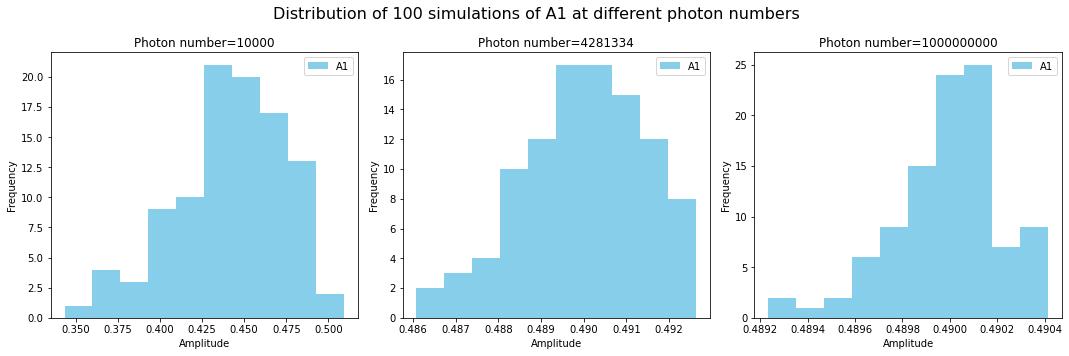

In [ ]:
# Setup for loop parameters
indices = [0, 10, 19]  # Indices for low, middle, high photon number
titles = ['Photon number=10000', 'Photon number=4281334', 'Photon number=1000000000']
colors = ['skyblue', 'skyblue', 'skyblue']  # Using the same color, but allows customization
bins = 10  # Assuming you want the same number of bins for each histogram

# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

for i, (index, title) in enumerate(zip(indices, titles)):
    axs[i].hist(n_val_df.loc[index, 'A1'], bins=bins, color=colors[i])
    axs[i].set_xlabel('Amplitude')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(title)
    axs[i].legend(['A1'])

# Add a main title for the plots
fig.suptitle('Distribution of 100 simulations of A1 at different photon numbers', fontsize=16)

# Adjust layout to prevent overlapping
plt.subplots_adjust(top=0.85)

plt.tight_layout()
plt.show()


In [ ]:
mean_df = n_val_df.groupby(level=0).mean()
std_df = n_val_df.groupby(level=0).std()

In [ ]:
mean_df

,c,A1,A2,tau1,tau2
0,3.641905,0.443062,0.556938,2.216590,2.945727
1,3.915720,0.461171,0.538829,2.276544,3.016053
2,4.921230,0.472944,0.527056,2.349057,3.016474
3,5.013423,0.476350,0.523650,2.386580,3.035590
4,6.675422,0.483971,0.516029,2.421343,3.033608
5,9.109749,0.486158,0.513842,2.419881,3.041040
6,11.966228,0.487054,0.512946,2.431600,3.041213
7,21.796761,0.487990,0.512010,2.425616,3.049218
8,26.398535,0.487875,0.512125,2.435953,3.045959
9,35.141721,0.489592,0.510408,2.422731,3.063324


In [ ]:
std_df

,c,A1,A2,tau1,tau2
0,2.502655,0.032864,0.032864,0.255493,0.132079
1,3.458502,0.021024,0.021024,0.176653,0.091799
2,4.557508,0.017388,0.017388,0.109603,0.076994
3,5.400703,0.013147,0.013147,0.132359,0.076419
4,6.475979,0.010426,0.010426,0.103684,0.082494
5,9.231790,0.008932,0.008932,0.080742,0.072381
6,13.769405,0.007479,0.007479,0.080775,0.078008
7,21.451255,0.006287,0.006287,0.061379,0.058835
8,25.461123,0.005932,0.005932,0.057422,0.055833
9,32.808203,0.002651,0.002651,0.027804,0.024287


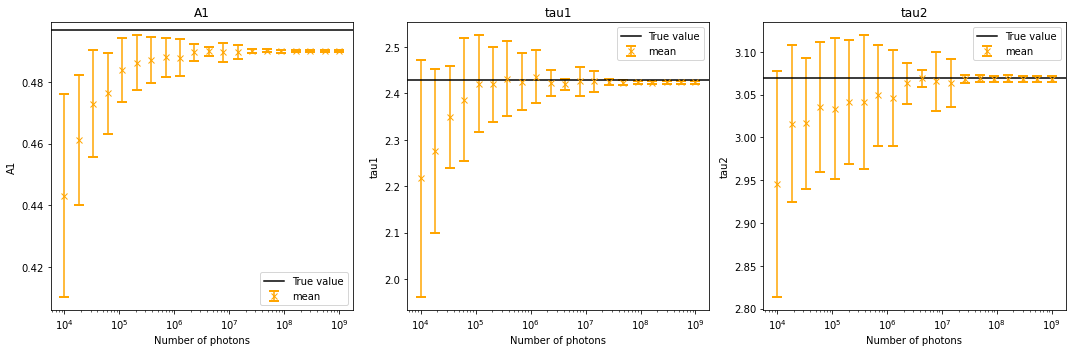

In [ ]:
# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
true = [0.497,2.43,3.07]
# A1 plot
for i in range(3):
    col = ['A1','tau1','tau2'][i] #column name
    axs[i].errorbar(n_photon_arr, mean_df[col], yerr=std_df[col], fmt='x', ecolor='orange', capthick=2,
                    capsize=5, color='orange', label='mean')
    axs[i].axhline(y=true[i], color='k', linestyle='-', label='True value')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Number of photons')
    axs[i].set_ylabel(col)
    axs[i].set_title(col)
    axs[i].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
par_dict = {k:v.value for k,v in mi1.params.items()}
A_sum = sum([par_dict[f'A{j}'] for j in range(1,N+1)])
for i in range(1,N+1):
  par_dict[f'A{i}']=par_dict[f'A{i}']/A_sum

In [ ]:
par_dict

{'c': 2.6261220976405935,
 'A1': 0.4119245809129398,
 'A2': 0.5880754190870602,
 'A3': 27.31554596339662,
 'tau1': 2.0589761595478713,
 'tau2': 3.1826795650414406,
 'tau3': 8.088133811301468e-05}

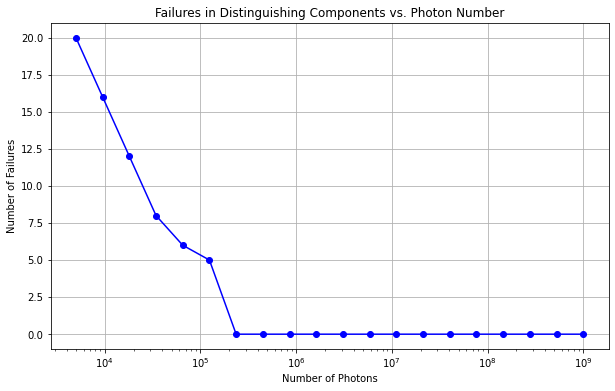

In [ ]:
# Reset failure_counts to ensure clean start
failure_counts = []

# Assuming n_photon_arr is defined and correctly populated
for n_photon in n_photon_arr:
    failures = 0
    for j in range(100):  # For each simulation
        EGFP.n_photon = n_photon
        EGFP.repeat_sim(100)
        # Assuming the simulation data EGFP.sim_data[j] is correctly populated
        # and MLEfit function works as expected
        fit_results_df = MLEfit(2, EGFP.t, EGFP.sim_data[j], method='powell', end=100, rescale=False)
        
        # Extract fitted values
        A1 = fit_results_df['A1'].iloc[0]
        A2 = fit_results_df['A2'].iloc[0]
        tau1 = fit_results_df['tau1'].iloc[0]
        tau2 = fit_results_df['tau2'].iloc[0]

        # Failure condition
        if np.isclose(tau1, tau2, atol=0.2) or A1 > 0.8 or A2 > 0.8:
            failures += 1
    
    failure_counts.append(failures)

# Plotting the number of failures vs. n_photon
plt.figure(figsize=(10, 6))
plt.plot(n_photon_arr, failure_counts, marker='o', linestyle='-', color='blue')
plt.xscale('log')
plt.xlabel('Number of Photons')
plt.ylabel('Number of Failures')
plt.title('Failures in Distinguishing Components vs. Photon Number')
plt.grid(True)
plt.show()


In [ ]:
# Assuming n_photon_arr is defined and correctly populated
chi2_failure_counts = []

for n_photon in n_photon_arr:
    chi2_failures = 0
    EGFP.n_photon = n_photon
    EGFP.repeat_sim(100)  # Generate simulation data
    for j in range(100):  # For each simulation    
        # Perform the chi-squared fit using the predefined method
        EGFP.fit(exp2, method='leastsq',end = np.where(EGFP.y2<10)[0])
        
        # Extract fitted values directly from EGFP.par
        A1 = EGFP.par['A1'].value
        A2 = EGFP.par['A2'].value
        tau1 = EGFP.par['tau1'].value
        tau2 = EGFP.par['tau2'].value

        # Check for failure conditions similar to the MLE method
        if np.isclose(tau1, tau2, atol=0.2) or A1 > 0.8 or A2 > 0.8:
            chi2_failures += 1

    chi2_failure_counts.append(chi2_failures)

# Plotting the number of failures for the chi-squared fit vs. n_photon
plt.figure(figsize=(10, 6))
plt.plot(n_photon_arr, chi2_failure_counts, marker='o', linestyle='-', color='red', label='Chi-squared Fit Failures')
plt.plot(n_photon_arr, failure_counts, marker='o', linestyle='-', color='blue', label='MLE Fit Failures')
plt.xscale('log')
plt.xlabel('Number of Photons')
plt.ylabel('Number of Failures')
plt.title('Comparison of Failures: MLE vs. Chi-squared Fit')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'n_photon_arr' is not defined